In [135]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

import warnings
warnings.filterwarnings('ignore')

<h1><center>KNN on Iris </center></h1>
<h5><center>Matthew Xu</center></h5>

In [136]:
#Loading Iris
iris = load_iris()

# Loading Iris data, target variable, feature names
data = iris.data 
target = iris.target 
names = iris.target_names
feature_names  = iris.feature_names

In [137]:
# Changing dataset to pandas dataframe 
df = pd.DataFrame(data, columns=iris.feature_names)
df['species'] = iris.target

In [138]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [140]:
# Feature variable to X
X = df.drop('species',axis=1)

# Response variable to y
y = df['species']

print(X)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]


Step-1: Select the number K of the neighbors
Step-2: Calculate the Euclidean distance of K number of neighbors
Step-3: Take the K nearest neighbors as per the calculated Euclidean distance.
Step-4: Among these k neighbors, count the number of the data points in each category.
Step-5: Assign the new data points to that category for which the number of the neighbor is maximum.
Step-6: Our model is ready.

<h3>Scratch KNN</h3>

In [141]:
# Calculate Euclidean distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [142]:
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

In [143]:
def minkowski_distance(x1, x2, p=3):
    return np.sum(np.abs(x1 - x2) ** p) ** (1/p)


In [144]:
# Uniform weights are identical, return weights of all ones
def uniform_weights(distances):
    return np.ones_like(distances)

In [145]:
# Distance Weights weighted by inverse distance squared
def distance_weights(distances):
    return 1 / (distances ** 2)  

In [146]:
class KNN:
    def __init__(self, k=5, distance_func=euclidean_distance, weight_func=uniform_weights):
        self.k = k
        self.distance_func = distance_func
        self.weight_func = weight_func

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = np.array([self.distance_func(x, x_train) for x_train in self.X_train])

        # Fincd k closest distances
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        k_nearest_distances = distances[k_indices]

        # Find the weights
        weights = self.weight_func(k_nearest_distances)

        # Weighted majority vote
        weighted_votes = {}
        for idx, label in enumerate(k_nearest_labels):
            weighted_votes[label] = weighted_votes.get(label, 0) + weights[idx]

        # Return the label with the highest weighted vote
        return max(weighted_votes, key=weighted_votes.get)
    
    def accuracy_score(self, y_true, y_pred):
        # Compute the accuracy by comparing true and predicted labels
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

In [147]:
X = iris.data
y = iris.target

# Traing and Test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
import time

# Instantiating model
scratchKNN = KNN(k=3, distance_func = euclidean_distance, weight_func = distance_weights)

# Fit model to training and test data
start_time_fit = time.time()
scratchKNN.fit(X_train, y_train)
end_time_fit = time.time()
print(f"Fit time: {end_time_fit - start_time_fit:.4f} seconds")

# Predict for test data
start_time_pred = time.time()
scratchPredictions = scratchKNN.predict(X_test)
end_time_pred = time.time()
print(f"Prediction time: {end_time_pred - start_time_pred:.4f} seconds")

Fit time: 0.0000 seconds
Prediction time: 0.0114 seconds


In [149]:
scratch_knn_accuracy = scratchKNN.accuracy_score(y_test, scratchPredictions)
print(f"Accuracy: {scratch_knn_accuracy}")

Accuracy: 1.0


<h3>SKLearn KNN</h3>

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
from sklearn.neighbors import KNeighborsClassifier
sk_knn = KNeighborsClassifier(n_neighbors=5)
sk_knn.fit(X_train, y_train)
y_pred = sk_knn.predict(X_test)

In [152]:
sk_knn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", sk_knn_accuracy)

Accuracy: 1.0


In [153]:
cv_scores = cross_val_score(sk_knn, X, y, cv=5)

In [154]:
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.96666667 1.         0.93333333 0.96666667 1.        ]
cv_scores mean:0.9733333333333334


<h3>Hyperparameter Tuning</h3>

In [155]:
from sklearn.model_selection import GridSearchCV

sk_knn_2 = KNeighborsClassifier()
# Create a dictionary of all values we want to test for knn
param_grid = {
    'n_neighbors': np.arange(1, 10), 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'minkowski', 'cityblock'] # city block is manhatten
                }
# Use gridsearch to test all values for n_neighbors
grid_search = GridSearchCV(sk_knn_2, param_grid, cv=5)
# Fit model to data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski', 'cityblock'],
                         'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'weights': ['uniform', 'distance']})

In [156]:
# Print the best score and the best estimator from grid search
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.9583333333333334
KNeighborsClassifier(metric='euclidean', n_neighbors=3)


In [157]:
# Final best tree model
final_knn = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

start_time_fit = time.time()
final_knn.fit(X_train, y_train)
end_time_fit = time.time()
print(f"Fit time: {end_time_fit - start_time_fit:.4f} seconds")

start_time_pred = time.time()
y_pred_final_knn = final_knn.predict(X_test)
end_time_pred = time.time()
print(f"Prediction time: {end_time_pred - start_time_pred:.4f} seconds")


Fit time: 0.0004 seconds
Prediction time: 0.0005 seconds


In [158]:
# Accuracy Score
final_tree_accuracy = accuracy_score(y_test, y_pred_final_knn)
print(final_tree_accuracy)

1.0


<h3>Plotting KNN</h3>

In [159]:
# Function to draw decison boundaries plot for any two features
def plot_knn_decision_boundaries(X_train, y_train, X_test, y_test, knn_model, feature_names):
    # Create a mesh grid for plotting decision boundaries
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the class labels for each point in the mesh grid
    Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', edgecolor='k', label='Training Data', s=100)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='s', edgecolor='k', label='Test Data', s=100)
    plt.title('KNN Classifier Decision Boundaries on Iris Dataset')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()
    plt.show()

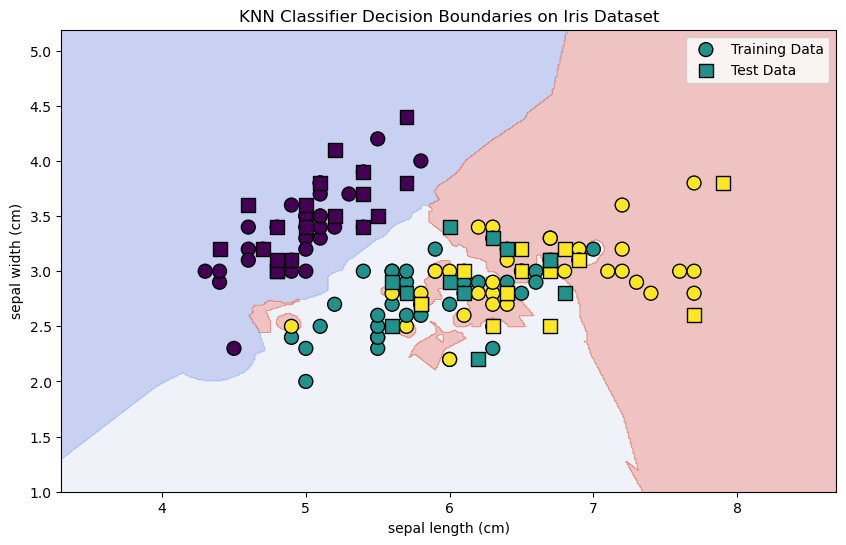

In [160]:
# Use only the first two features for 2D visualization
vis_X = iris.data[:, :2]
vis_y = iris.target

# Training and Testing sets 
X_train, X_test, y_train, y_test = train_test_split(vis_X, vis_y, test_size=0.3, random_state=42)

# KNN classifier using gridsearch best parameters
vis_knn = KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

# Fit model to training data
vis_knn.fit(X_train, y_train)

# Call the plotting function
plot_knn_decision_boundaries(X_train, y_train, X_test, y_test, vis_knn, iris.feature_names)

<h3>Conclusion</h3>



In comparing the custom scratch implementation of the K-Nearest Neighbors algorithm with the Sklearn KNN model with the same exact hyperparamaters using the Iris dataset, both achieved an accuracy of 100%. However, the Sklearn model demonstrated better performance with a faster prediction time (0.0012 seconds vs. 0.0118 seconds) and a slightly longer fitting time (0.0006 seconds vs. 0.0000 sec). The Sklearn version is better than the self implelemted scratch knn due to its efficiency and robustness, especially when handling larger and more complex datasets.